You have been provided with 3 excel workbooks. Namely,

1. Box Placement
2. Wet Harvest
3. Dry Harvest

The workbooks are a result of the enumerators filling in box placement, wet harvest and dry harvest forms during the crop cuts experiment process.

The crop cuts experiment process is a process whereby enumerators are hired, trained and visit farmers to go and measure their yields. We equip the enumerators with a digital survey data collection application called Mavuno. 

These enumerators conduct 3 farm visits. 
The first visit is called box placement. It is during this visit that they get to fill the box placement survey. The key information captured by box placement measurement form is the farmers identification details, the size and the number of the boxes placed, the number of crops in the farm, the health of the crops, the GPS location of the farm and the picture of the farm.

The main activity conducted during the second visit is to measure the fresh weight of the harvest. We have labelled this activity wet harvesting. The wet harvest measurement form is used to record the weight of the crops immediately harvested from the boxes randomly placed on the farm. 

Later on after the crops are dried, our enumerators conduct a third visit to go and measure the dry weights of the crops harvested. The dry weights are recorded using a dry harvest measurement form.

The enumerators normally place 2 boxes on the farm. The standard dimensions of these boxes are 8 meters by 5 meters. It is from these boxes that the enumerators harvest and not the whole field. A protocol is normally provided to guide the enumerators on how to place the boxes in an objective way. Sometimes due to obstacles on the field the enumerator is forced to place one box or revise the standard dimension. The dimensions of the box are normally captured under the box placement form.


Objective:

Obtain the average yield per hectare per district in metric tonnes using cleaned data.  Note that the enumerators have reported their weights in kgs.


Tasks
1. Merge the three forms using the field labelled @case_id using Google sheet, Excel, R, Python or whichever tool you deem fit.
2. You are to find enumerators who are likely not entering correct data (use username column to identify enumerators).  Some indications of this are:
               1. Crazy box dimensions
               2. False zero yields
               3. Dry weight exceeding wet weight
               4. Non-compliant data sets i.e no box dimension yet there is yield data captured. Zero wet weight yield but greater than zero dry weight, harvest crop mixed with other crops
               5. Note that other variables in the dataset might also explain funny results, check other variables.  You can also look for those types of variables. 
3. Use the box placement latitude and longitude, to come up with a spatial distribution of the data points on a map (you can use tools such as QGIS, Google Maps, ArcGIS or whichever tool you deem fit).  Consider this as well when assessing enumerator performance
4. Compute the average yield in Mt/Ha for each observation, using the dry weight
5. Create filters in a new column or columns to determine which types of yields we should consider outliers or errors and fill those columns so that we can filter the outliers on and off as needed. (if using code, clearly show these filters)
6. Identify major problems affecting the crops per district or state. Use box1_problem column. Is there consistency?
7. Write a short and easy to understand report to share with your supervisor. The report should:
           - Show what you think the average yields per hectare in Metric tonnes are, having filtered out/cleaned erroneous data.
           - Explain the erroneous data you filtered/cleaned out and how (be clear, use bullet point type explanations)
           - Show the major factors/problems affecting the crops per district and determine if there are any inconsistencies 
           - Explain if you think any enumerators submitted data that was suspicious to the level of needing to be terminated. 


1. Loading the Dataset

In [1]:
import pandas as pd

# Load the datasets
box_placement = pd.read_excel('Box Placement.xlsx')
wet_harvest = pd.read_excel('Wet Harvest.xlsx')
dry_harvest = pd.read_excel('Dry Harvest.xlsx')

# Merge datasets on @case_id
merged_df = box_placement.merge(wet_harvest, on='@case_id', suffixes=('_box', '_wet'))
merged_df = merged_df.merge(dry_harvest, on='@case_id', suffixes=('', '_dry'))

# Inspect the merged dataframe
print(merged_df.head())


  client_name distance_to_water_body enumerator_comment_box  \
0           A         More_than_5_KM       successfuly done   
1           A         More_than_5_KM                     ok   
2           A         More_than_5_KM                     ok   
3           A         More_than_5_KM                     ok   
4           A         More_than_5_KM                     ok   

  expected_harvest_date farmer_in_list_or_control farmer_state_district  \
0            2022-05-27            control_farmer               Katsina   
1            2022-06-08            control_farmer               Zamfara   
2            2022-06-06            control_farmer               Zamfara   
3            2022-06-16            control_farmer               Zamfara   
4            2022-06-13            control_farmer               Zamfara   

  field_irrigated insured_crop intercropping  \
0              no        wheat            no   
1              no        wheat            no   
2              no        w

In [5]:
merged_df.shape

(2187, 121)

In [10]:
print(list(merged_df.columns))

['client_name', 'distance_to_water_body', 'enumerator_comment_box', 'expected_harvest_date', 'farmer_in_list_or_control', 'farmer_state_district', 'field_irrigated', 'insured_crop', 'intercropping', 'other_factors_that_affected_germination', 'planting_date', 'success_box1', 'success_box2', 'ward_lga_subcounty_camp', 'box1_crop_condition', 'box1_crop_stands_per_square_meter', 'box1_dim_8_by_5', 'box1_length', 'box1_mode_of_planting', 'box1_other_issues_occurrence_date', 'box1_other_problems', 'box1_problem', 'box1_secondary_issues', 'box1_width', 'box2_crop_condition', 'box2_crop_stands_per_square_meter', 'box2_dim_8_by_5', 'box2_length', 'box2_mode_of_planting', 'box2_other_issues_occurrence_date', 'box2_other_problems', 'box2_problem', 'box2_secondary_issues', 'box2_width', '@case_id', 'timeEnd_box', 'timeStart_box', 'type_of_pests_or_diseases_current_crop_stage', 'what_steps_did_the_farmer_take_to_mitigate_the_pests_or_diseases', 'why_unable_to_place_box1', 'type_of_irrigation_system

In [12]:
merged_df.box1_wet_weight

0       7.885
1       2.970
2       2.255
3       3.255
4       2.510
        ...  
2182    7.600
2183    6.540
2184    8.105
2185    6.160
2186    6.140
Name: box1_wet_weight, Length: 2187, dtype: float64

2. Identify Enumerators with Potentially Incorrect Data

In [14]:
# Filter for crazy box dimensions for both box 1 and box 2
crazy_dimensions_box1 = (merged_df['box1_length'] > 20) | (merged_df['box1_width'] > 20) | (merged_df['box1_length'] <= 0) | (merged_df['box1_width'] <= 0)
crazy_dimensions_box2 = (merged_df['box2_length'] > 20) | (merged_df['box2_width'] > 20) | (merged_df['box2_length'] <= 0) | (merged_df['box2_width'] <= 0)

# Combine the conditions
crazy_dimensions = crazy_dimensions_box1 | crazy_dimensions_box2
# Filter for false zero yields
false_zero_yields_box1 = (merged_df['box1_wet_weight'] == 0) & (merged_df['box1_dry_weight'] > 0)
false_zero_yields_box2 = (merged_df['box2_wet_weight'] == 0) & (merged_df['box2_dry_weight'] > 0)
false_zero_yields = false_zero_yields_box1 | false_zero_yields_box2

# Filter for dry weight exceeding wet weight
dry_exceeds_wet_box1 = merged_df['box1_dry_weight'] > merged_df['box1_wet_weight']
dry_exceeds_wet_box2 = merged_df['box2_dry_weight'] > merged_df['box2_wet_weight']
dry_exceeds_wet = dry_exceeds_wet_box1 | dry_exceeds_wet_box2

# Filter for non-compliant datasets (missing box dimensions or inconsistencies in weights)
non_compliant_box1 = (merged_df['box1_length'].isnull() | merged_df['box1_width'].isnull())
non_compliant_box2 = (merged_df['box2_length'].isnull() | merged_df['box2_width'].isnull())
non_compliant_weights = ((merged_df['box1_wet_weight'] == 0) & (merged_df['box1_dry_weight'] > 0)) | \
                        ((merged_df['box2_wet_weight'] == 0) & (merged_df['box2_dry_weight'] > 0))
non_compliant = non_compliant_box1 | non_compliant_box2 | non_compliant_weights

# Aggregate all suspicious cases
suspicious_cases = crazy_dimensions | false_zero_yields | dry_exceeds_wet | non_compliant

# Filter out suspicious rows
suspicious_data = merged_df[suspicious_cases]

# Display suspicious enumerators
suspicious_enumerators = suspicious_data['username'].unique()
print("Suspicious Enumerators:", suspicious_enumerators)


Suspicious Enumerators: ['nig039' 'nig099' 'nig188' 'nig168' 'nig108' 'nig137' 'nig187' 'nig184'
 'nig044' 'nig075' 'nig183' 'nig114' 'nig118' 'nig186' 'nig180' 'nig048'
 'nig037' 'nig106' 'nig175' 'nig120' 'nig111' 'nig185' 'nig098' 'nig102'
 'nig090' 'nig105' 'nig097' 'nig100' 'nig174' 'nig103' 'nig104' 'nig133'
 'nig132' 'nig028' 'nig030' 'nig026' 'nig033' 'nig027' 'nig024' 'nig035'
 'nig034' 'nig031' 'nig036' 'nig025' 'nig021']


3. Spatial Distribution of Data Points

In [16]:
pip install geopandas

     -------------------------------------- 51.5/51.5 kB 125.9 kB/s eta 0:00:00
     ---------------------------------------- 61.0/61.0 kB 3.2 MB/s eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.26.4 which is incompatible.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.26.4 which is incompatible.
ydata-profiling 4.2.0 requires numpy<1.24,>=1.16.0, but you have numpy 1.26.4 which is incompatible.



   ---------------------------------------- 1.1/1.1 MB 74.6 kB/s eta 0:00:00
   ---------------------------------------- 22.9/22.9 MB 52.1 kB/s eta 0:00:00
   ---------------------------------------- 15.8/15.8 MB 44.7 kB/s eta 0:00:00
   ---------------------------------------- 6.1/6.1 MB 50.6 kB/s eta 0:00:00
   ---------------------------------------- 1.4/1.4 MB 44.3 kB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5


C:\Users\HP\AppData\Local\Temp\ipykernel_14092\1908558062.py:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


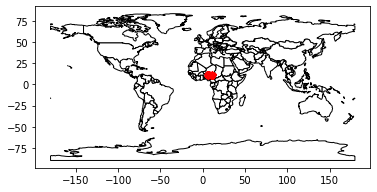

In [17]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Convert latitude and longitude to geometry
geometry = [Point(xy) for xy in zip(merged_df['longitude'], merged_df['latitude'])]
geo_df = gpd.GeoDataFrame(merged_df, geometry=geometry)

# Plot the data points
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world.plot(color='white', edgecolor='black')
geo_df.plot(ax=base, marker='o', color='red', markersize=5)
plt.show()


4. Compute the Average Yield in Mt/Ha

In [21]:
# Calculate the area for both boxes, handling possible missing values
merged_df['box1_area_ha'] = (merged_df['box1_length'] * merged_df['box1_width']) / 10000
merged_df['box2_area_ha'] = (merged_df['box2_length'] * merged_df['box2_width']) / 10000

# Sum the areas to get the total sampled area
merged_df['totalbox_area_ha'] = merged_df['box1_area_ha'].fillna(0) + merged_df['box2_area_ha'].fillna(0)

# Sum the dry weights from both boxes to get the total dry weight
merged_df['total_dry_weight'] = merged_df['box1_dry_weight'].fillna(0) + merged_df['box2_dry_weight'].fillna(0)

# Compute yield per hectare in metric tonnes
merged_df['yield_mt_ha'] = (merged_df['total_dry_weight'] / 1000) / merged_df['totalbox_area_ha']

# Compute average yield per district
average_yield_per_district = merged_df.groupby('farmer_state_district')['yield_mt_ha'].mean().reset_index()
print(average_yield_per_district)


   farmer_state_district  yield_mt_ha
0                   Abia     0.675000
1                Adamawa     0.774035
2                 Bauchi     1.284659
3                  Borno     0.557774
4                  Gombe     1.997719
5                 Jigawa     1.137279
6                 Kaduna     1.819190
7                   Kano     1.503620
8                Katsina     0.647629
9                  Kebbi     1.303163
10                 Niger     0.499073
11                Sokoto     1.604448
12                Taraba     0.548271
13                  Yobe     0.851230
14               Zamfara     0.477544


5. Create Filters for Outliers or Errors

In [22]:
# Create filter columns
merged_df['crazy_dimensions'] = crazy_dimensions
merged_df['false_zero_yields'] = false_zero_yields
merged_df['dry_exceeds_wet'] = dry_exceeds_wet
merged_df['non_compliant'] = non_compliant

# Add an overall error flag
merged_df['error_flag'] = suspicious_cases

# Save the cleaned dataset for further analysis
cleaned_df = merged_df[~suspicious_cases]
cleaned_df.to_csv('cleaned_data.csv', index=False)


6. Identify Major Problems Affecting the Crops per District

In [28]:
# Count problems per district
problems_per_district = merged_df.groupby(['farmer_state_district', 'box1_problem']).size().unstack(fill_value=0)
problems_per_district

box1_problem,animal_cattle_encroachment,animal_cattle_encroachment late_planting,animal_cattle_encroachment weeds,animal_cattle_encroachment weeds late_planting,drought,drought animal_cattle_encroachment,drought animal_cattle_encroachment late_planting,drought animal_cattle_encroachment weeds late_planting,drought late_planting,drought locust_infestation,...,poor_germination locust_infestation other_pest_and_disease weeds,poor_germination locust_infestation other_pest_and_disease weeds late_planting,poor_germination locust_infestation weeds late_planting,poor_germination other_pest_and_disease,poor_germination others,poor_germination weeds,poor_germination weeds late_planting,weeds,weeds late_planting,weeds late_planting others
farmer_state_district,,,,,,,,,,,,,,,,,,,,,
Adamawa,0,1,0,0,11,0,0,0,0,0,...,0,0,0,0,1,8,0,8,0,0
Bauchi,0,0,1,0,9,0,0,0,1,1,...,0,0,1,1,0,0,0,16,2,1
Borno,0,0,0,0,16,0,0,0,15,0,...,0,0,0,0,0,0,0,0,0,0
Jigawa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Kaduna,1,1,0,0,3,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Kano,0,0,0,0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Katsina,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Niger,0,3,0,3,20,0,2,1,2,0,...,3,2,0,0,0,0,3,1,11,0
Sokoto,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0


7. Data Report

In [29]:
report = """
Crop Cuts Report

1. Average Yields per Hectare in Metric Tonnes:
   After filtering erroneous data, the average yields per hectare per district are:
   {}
   
2. Erroneous Data Filtered/Cleaned Out:
   - Crazy Box Dimensions: Box dimensions that were too large or too small.
   - False Zero Yields: Cases where dry weight was recorded but wet weight was zero.
   - Dry Weight Exceeding Wet Weight: Instances where dry weight exceeded wet weight.
   - Non-Compliant Data Sets: Entries with missing box dimensions or inconsistent weight data.
   
3. Major Problems Affecting Crops per District:
   The following problems were reported by district:
   {}
   
4. Suspicious Enumerators:
   The following enumerators were flagged for potentially incorrect data entry and may require further investigation:
   {}
""".format(average_yield_per_district.to_string(index=False), problems_per_district.to_string(), ', '.join(suspicious_enumerators))
